## Imports

In [55]:
import numpy as np
import os
import glob
import math

import nibabel as nib
from nibabel.filebasedimages import FileBasedImage

import matplotlib.pyplot as plt
import cv2

from skimage import measure
from skimage import morphology
from scipy import ndimage
from scipy.spatial import ConvexHull
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import watershed

## Utils functions

In [56]:
def read_nii(nii_path):
    nii = nib.load(nii_path)
    nii_data = nii.get_fdata()
    return nii_data

def dice_coeff(A, B):
    intersection = np.sum(A * B)
    size_A = np.sum(A)
    size_B = np.sum(B)
    return (2. * intersection) / (size_A + size_B)

def hausdorff_dist(A, B):
    # calculate the directed hausdorff distance in 3d
    A = np.array(np.where(A)).T
    B = np.array(np.where(B)).T
    dA, _, _ = directed_hausdorff(A, B)
    dB, _, _ = directed_hausdorff(B, A)
    return max(dA, dB)


def show_selected_slice(nib_img, slice_idx, title):
    plt.figure()
    plt.imshow(nib_img[:, :, slice_idx], cmap='gray')
    plt.title(title)
    plt.show()

def side_by_side(left_img, right_img, title, selected_slice=80):
    plt.gray()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].imshow(left_img[:, :, selected_slice], cmap='gray')
    axes[1].imshow(right_img[:, :, selected_slice], cmap='gray')
    fig.suptitle(title)
    plt.show()

def compare_lungs(left_lungs, ref_left_lungs, right_lungs, ref_right_lungs, selected_slice=80):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    plt.gray()

    # Title
    axes[0][0].set_title('Left Lungs')
    axes[0][1].set_title('Reference Left Lungs')
    axes[1][0].set_title('Right Lungs')
    axes[1][1].set_title('Reference Right Lungs')
    # Show images
    axes[0][0].imshow(left_lungs[:, :, selected_slice])
    axes[0][1].imshow(ref_left_lungs[:, :, selected_slice])
    axes[1][0].imshow(right_lungs[:, :, selected_slice])
    axes[1][1].imshow(ref_right_lungs[:, :, selected_slice])
    plt.show()

In [57]:
def segmentation_helper(lung_watershed, reference_lung, selected_lung=1):
    """
    lung: segmented lung
    reference_lung: reference lung
    watershed_img: watershed segmented image
    selected_lung: 1 for left lung, 2 for right lung
    """
    lung = np.zeros(lung_watershed.shape)
    lung[lung_watershed == selected_lung] = 1
    reference = np.zeros(reference_lung.shape)
    reference[reference_lung == selected_lung + 1] = 1
    return lung, reference

## Lung segmentation

In [58]:
def lung_segmentation(nib_img_path: FileBasedImage, bodymask_path: FileBasedImage, threshold=-320):
    tk = read_nii(nib_img_path)
    bm_img = read_nii(bodymask_path)
    # Thresholding
    _, binarized = cv2.threshold(tk, threshold, 1, cv2.THRESH_BINARY_INV)
    # Masking
    masked = cv2.bitwise_and(binarized, bm_img)
    blurred = cv2.medianBlur(masked.astype(np.float32), 5)
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((5, 5)))

    # # Fill holes
    # segmented = ndimage.binary_fill_holes(closed)
    # # Remove small components
    # segmented = morphology.remove_small_objects(segmented, min_size=10000)
    # # Remove small holes
    # segmented = morphology.remove_small_holes(segmented, area_threshold=10000)
    
    return closed


def preform_watershed(nib_image, reference_image_path, selected_slice = 80):
    ref_ct = read_nii(reference_image_path) 
    left_lungs = list()
    right_lungs = list()
    ref_left_lungs = list()
    ref_right_lungs = list()
    depth = nib_image.shape[2]
    for i in range(depth):
        img = nib_image[:, :, i]
        ref_img = ref_ct[:, :, i]

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8))
        segmented = watershed(img, labels, mask=labels)
        
        left_lung, ref_left_lung = segmentation_helper(segmented, ref_img, 1)
        left_lungs.append(left_lung)
        ref_left_lungs.append(ref_left_lung)

        right_lung, ref_right_lung = segmentation_helper(segmented, ref_img, 2)
        right_lungs.append(right_lung)
        ref_right_lungs.append(ref_right_lung)

    left_lungs = np.dstack(left_lungs)
    ref_left_lungs = np.dstack(ref_left_lungs)
    right_lungs = np.dstack(right_lungs)
    ref_right_lungs = np.dstack(ref_right_lungs)

    return left_lungs, ref_left_lungs, right_lungs, ref_right_lungs

## Vars

In [59]:
nib_fname = './Images/IMG_0001.nii.gz'
bm_fname = './Bodymasks/BODYMASK_IMG_0001.nii.gz'
ref_nib_fname = './ReferenceSegmentations/LUNGS_IMG_0001.nii.gz'

## Test Run

In [60]:
closed = lung_segmentation(nib_fname, bm_fname)

Dice coefficient: 0.9785104234821285


<Figure size 640x480 with 0 Axes>

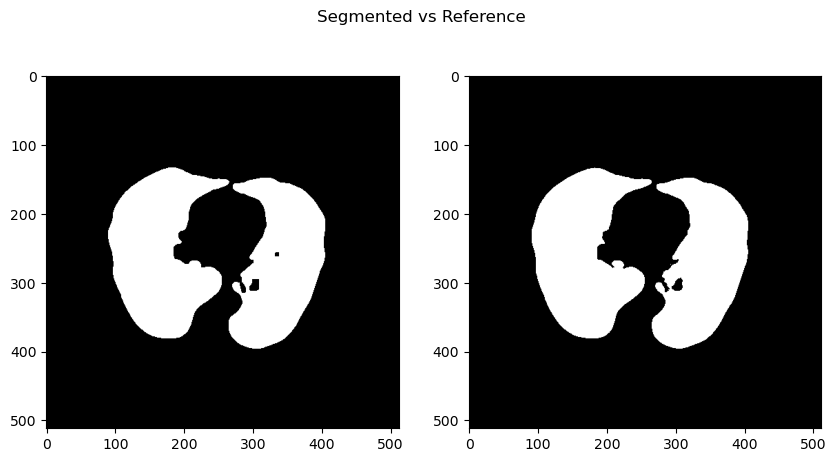

In [61]:
ref_ct = read_nii(ref_nib_fname)
selected = np.zeros(ref_ct.shape)
selected[ref_ct > 0] = 1
print(f"Dice coefficient: {dice_coeff(closed, selected)}")
# print(f"Hausdorff distance: {hausdorff_dist(closed, selected)}") takes very long
side_by_side(closed, selected, "Segmented vs Reference", selected_slice=80)


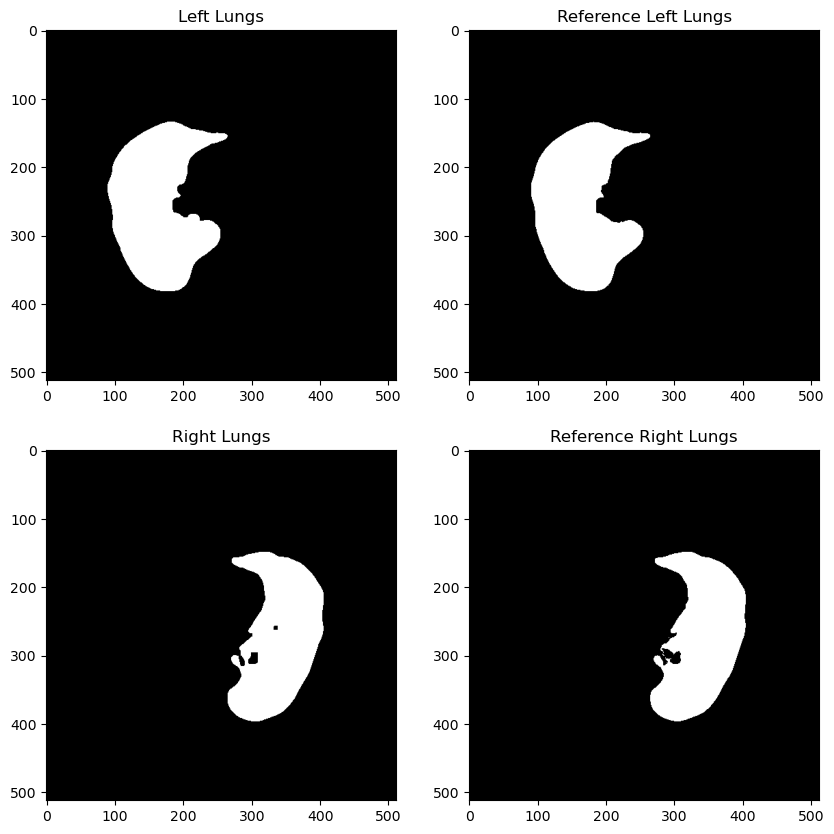

Left lung Dice coefficient: 0.8427735836817787
Right lung Dice coefficient: 0.7589997308469547


In [62]:
left_lungs, ref_left_lungs, right_lungs, ref_right_lungs = preform_watershed(closed, ref_nib_fname)

compare_lungs(left_lungs, ref_left_lungs, right_lungs, ref_right_lungs)
print(f"Left lung Dice coefficient: {dice_coeff(ref_left_lungs, left_lungs)}")
print(f"Right lung Dice coefficient: {dice_coeff(ref_right_lungs, right_lungs)}")

## All Imgs

Processing ./Images\IMG_0001.nii.gz, ./Bodymasks\BODYMASK_IMG_0001.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0001.nii.gz
Dice coefficient: 0.9785104234821285


<Figure size 640x480 with 0 Axes>

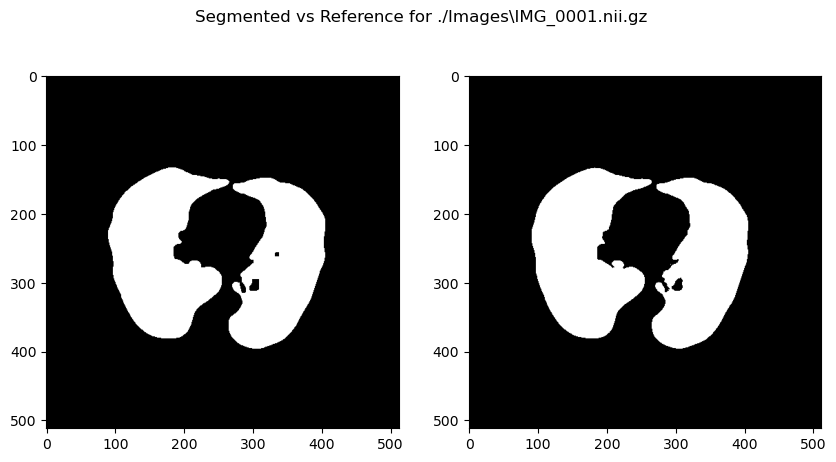

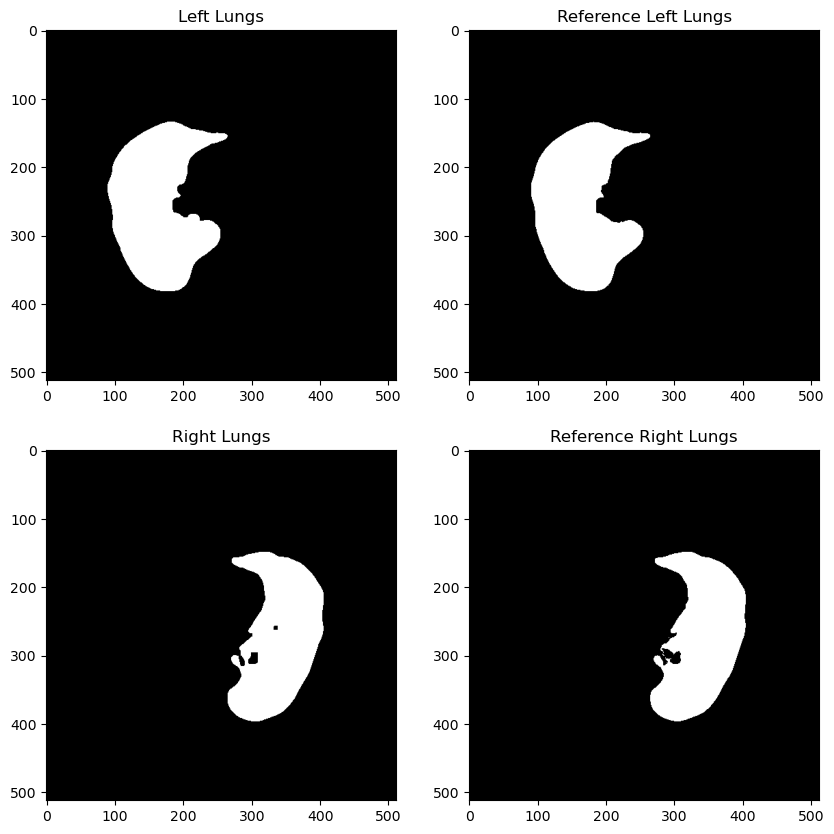

Left lung Dice coefficient: 0.8427735836817787
Right lung Dice coefficient: 0.7589997308469547
Processing ./Images\IMG_0007.nii.gz, ./Bodymasks\BODYMASK_IMG_0007.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0007.nii.gz
Dice coefficient: 0.9829960684978496


<Figure size 640x480 with 0 Axes>

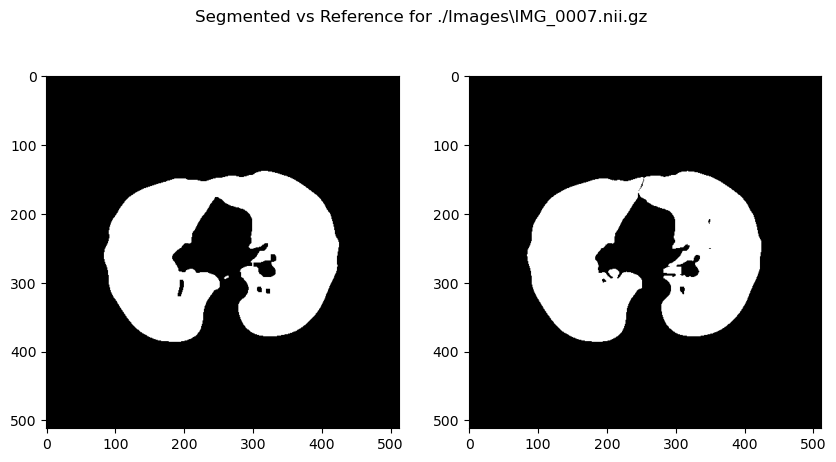

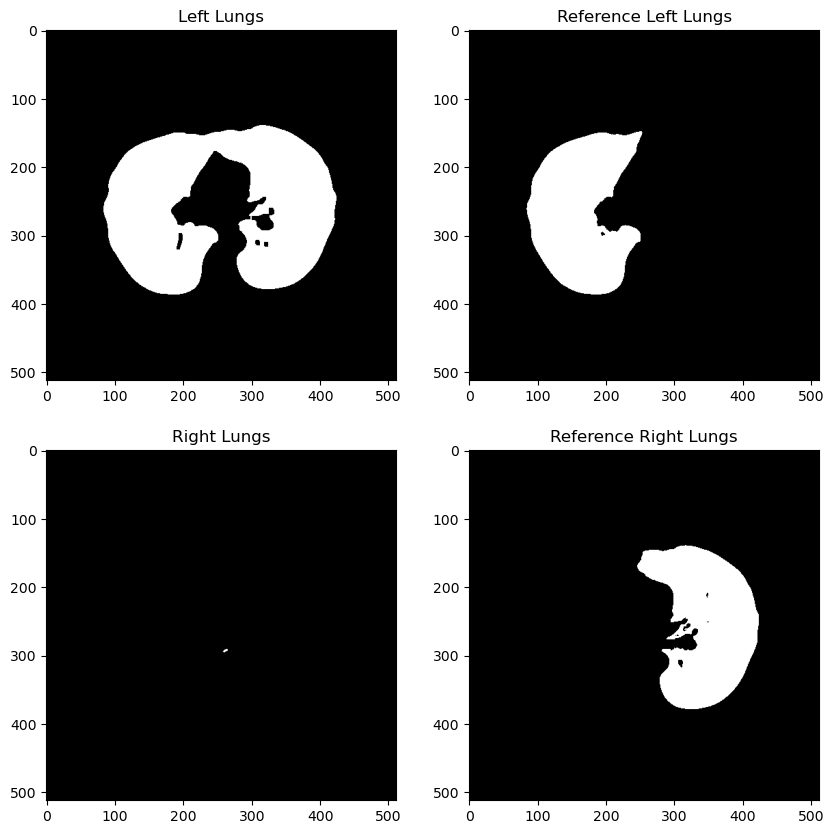

Left lung Dice coefficient: 0.5571588288427874
Right lung Dice coefficient: 0.2668320389379036
Processing ./Images\IMG_0010.nii.gz, ./Bodymasks\BODYMASK_IMG_0010.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0010.nii.gz
Dice coefficient: 0.9840001948645323


<Figure size 640x480 with 0 Axes>

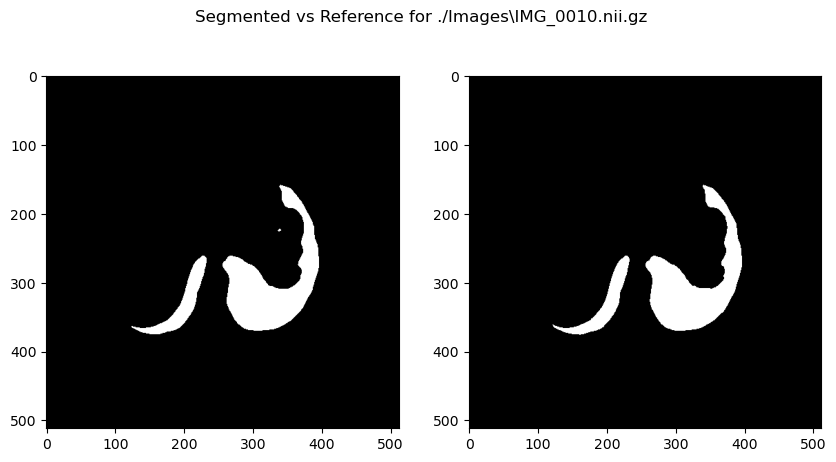

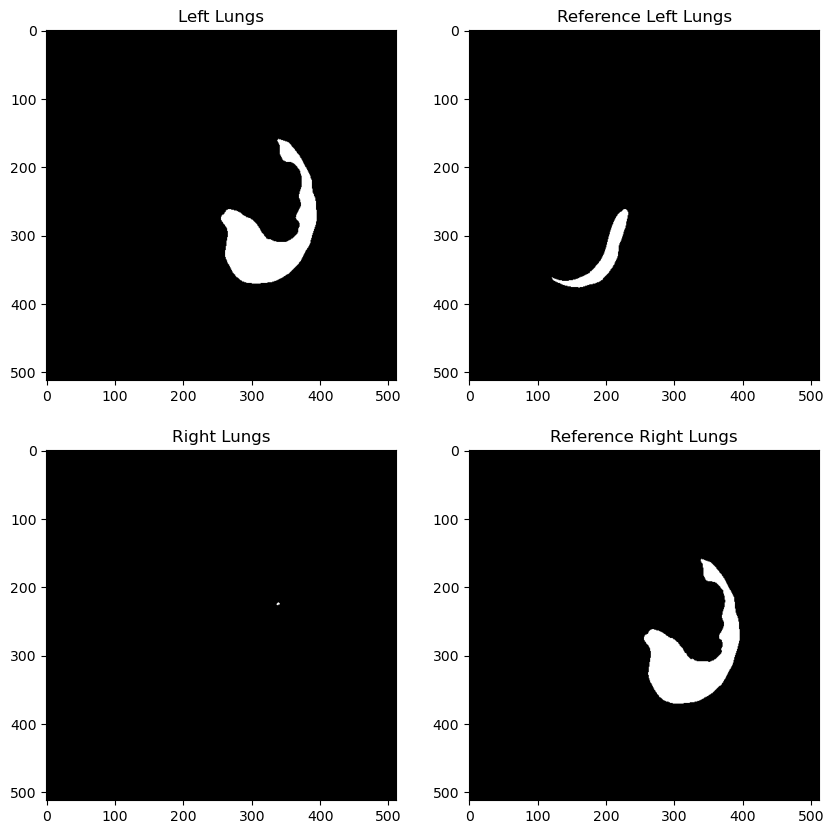

Left lung Dice coefficient: 0.00600788716839133
Right lung Dice coefficient: 0.07133860210517337
Processing ./Images\IMG_0011.nii.gz, ./Bodymasks\BODYMASK_IMG_0011.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0011.nii.gz
Dice coefficient: 0.9282018671883567


<Figure size 640x480 with 0 Axes>

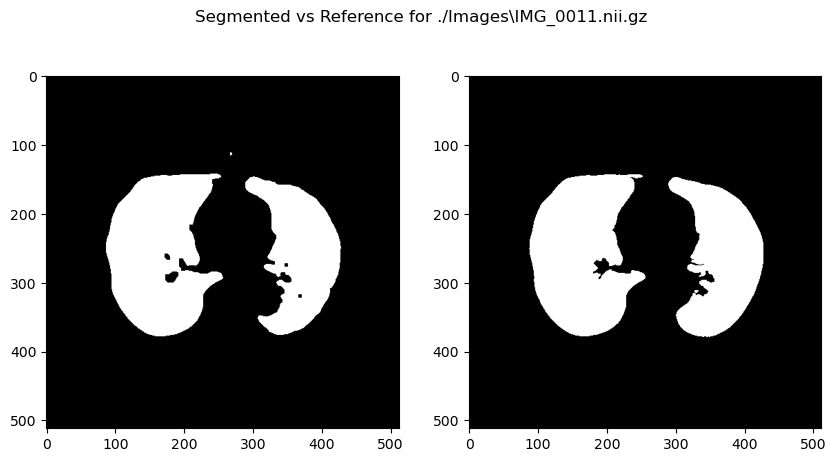

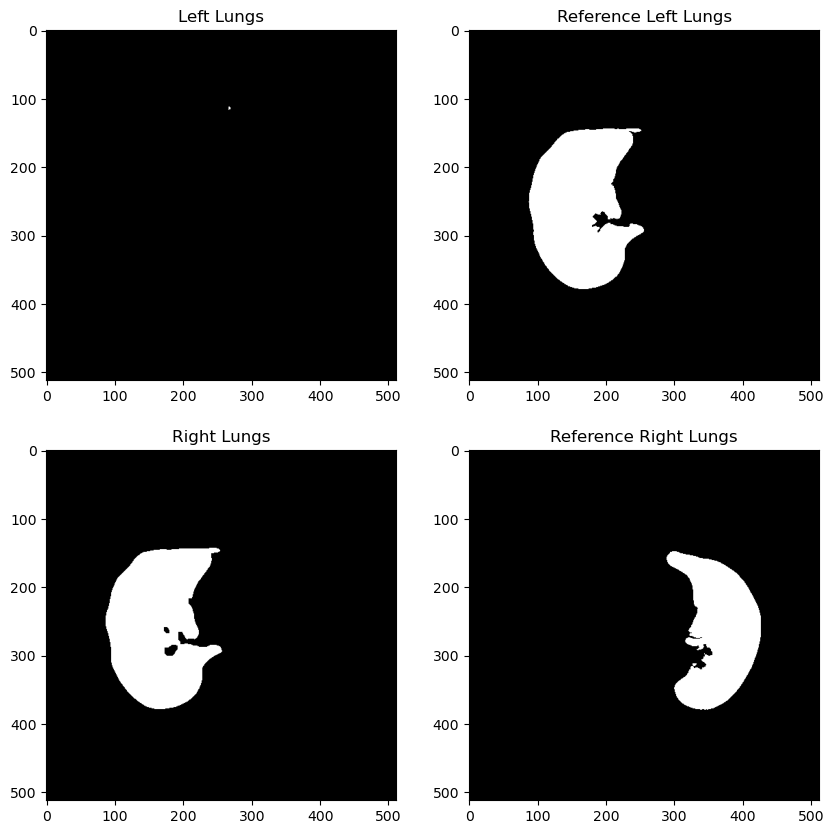

Left lung Dice coefficient: 0.8480445890884301
Right lung Dice coefficient: 0.6777466884394142
Processing ./Images\IMG_0012.nii.gz, ./Bodymasks\BODYMASK_IMG_0012.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0012.nii.gz
Dice coefficient: 0.9784414379501708


<Figure size 640x480 with 0 Axes>

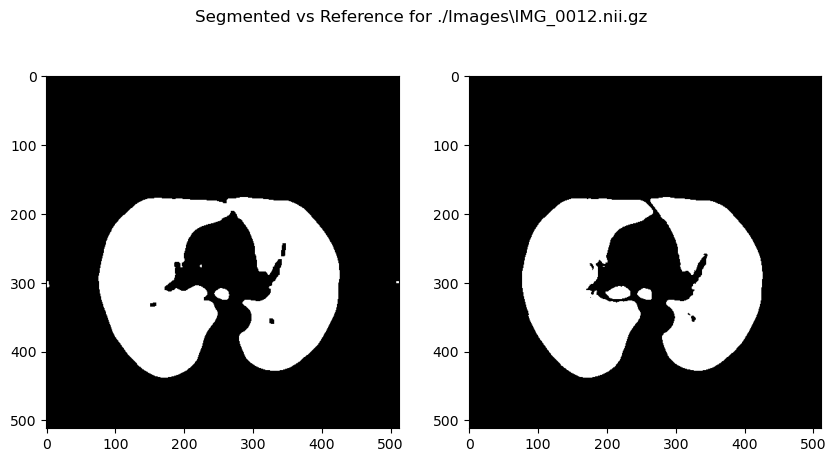

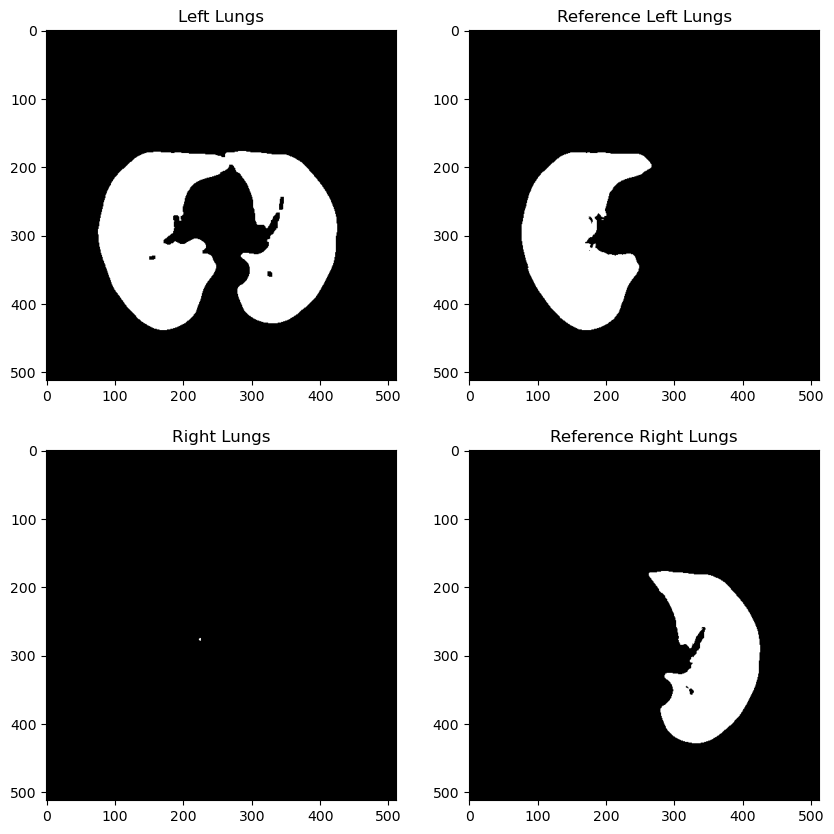

Left lung Dice coefficient: 0.6284007203892291
Right lung Dice coefficient: 0.5082290876408234
Processing ./Images\IMG_0013.nii.gz, ./Bodymasks\BODYMASK_IMG_0013.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0013.nii.gz
Dice coefficient: 0.977455979622938


<Figure size 640x480 with 0 Axes>

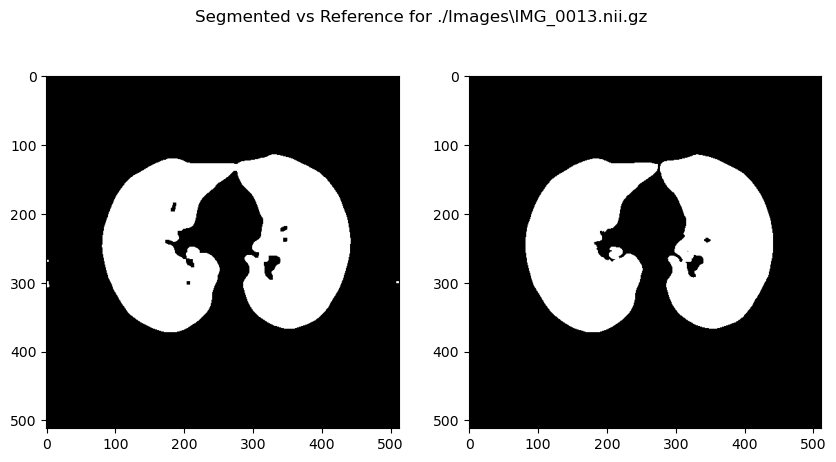

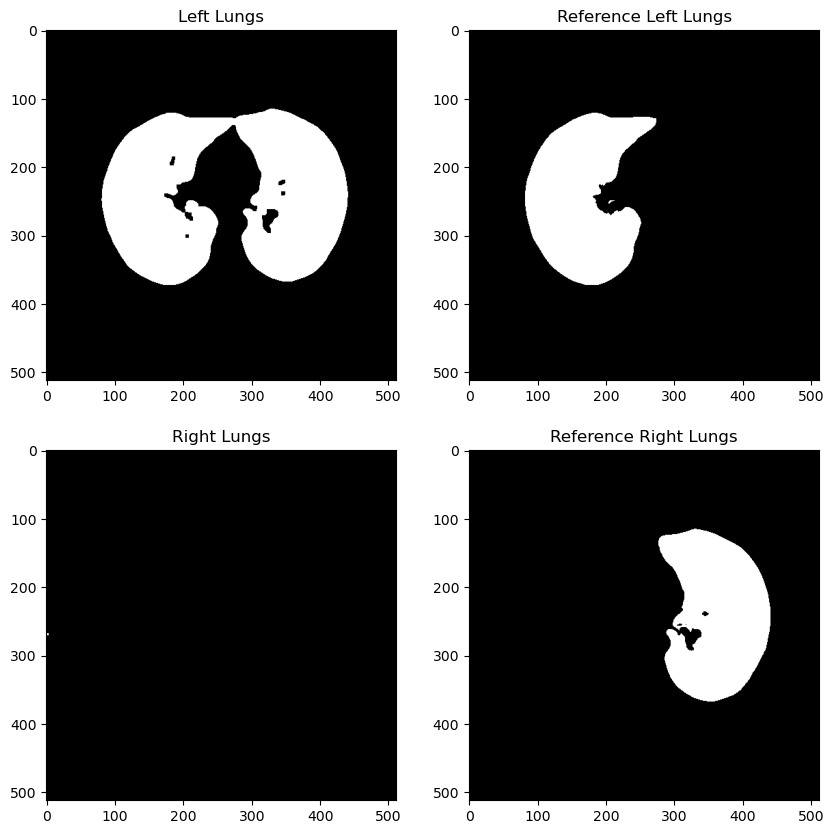

Left lung Dice coefficient: 0.43197739076360553
Right lung Dice coefficient: 0.19267679273621222
Processing ./Images\IMG_0014.nii.gz, ./Bodymasks\BODYMASK_IMG_0014.nii.gz, ./ReferenceSegmentations\LUNGS_IMG_0014.nii.gz
Dice coefficient: 0.9511353608734019


<Figure size 640x480 with 0 Axes>

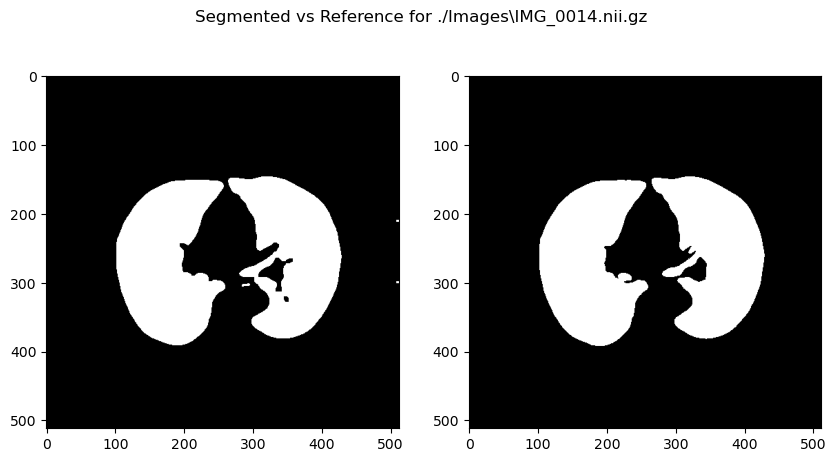

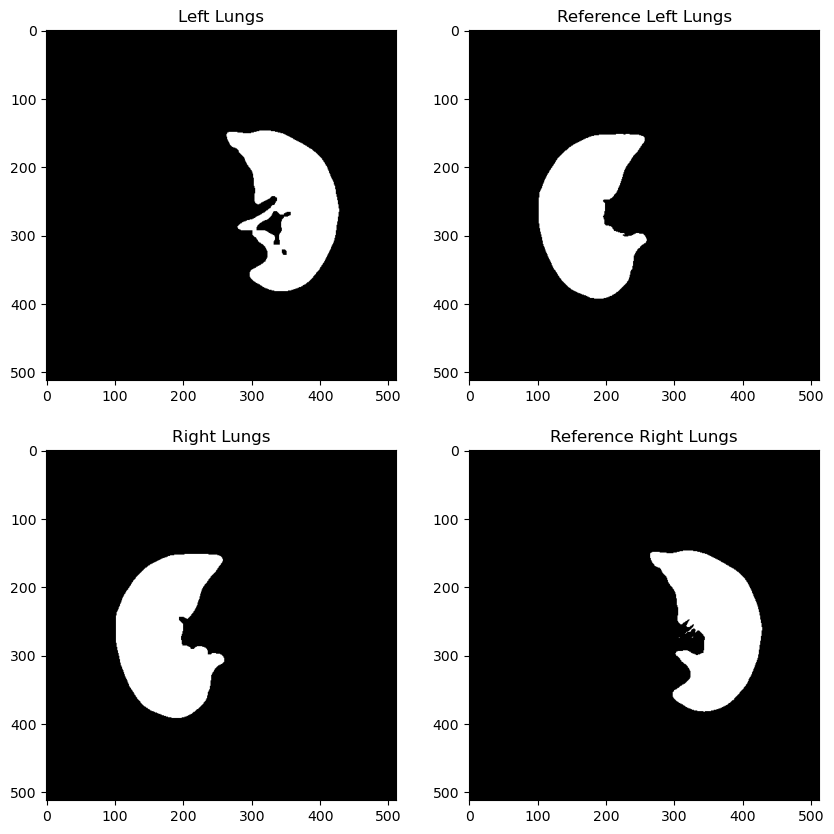

Left lung Dice coefficient: 0.3318616541200781
Right lung Dice coefficient: 0.19129638311306463


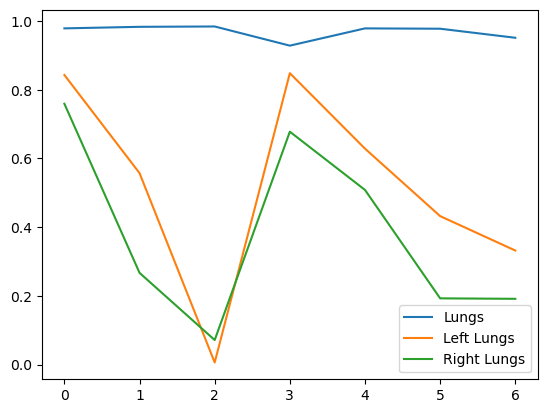

Average Dice coefficient for lungs: 0.9686773332113398
Average Dice coefficient for left lungs: 0.5208892362934715
Average Dice coefficient for right lungs: 0.3810170462599352


In [63]:
images_paths = glob.glob('./Images/*.nii.gz')
bodymasks_paths = glob.glob('./Bodymasks/*.nii.gz')
ref_paths = glob.glob('./ReferenceSegmentations/*.nii.gz')
if len(images_paths) != len(bodymasks_paths) or len(images_paths) != len(ref_paths):
    raise ValueError("Number of images, bodymasks and reference segmentations should be equal")

# Sort paths
images_paths.sort()
bodymasks_paths.sort()
ref_paths.sort()


dice_coefficients = []
left_dice_coefficients = []
right_dice_coefficients = []

for i in range(len(images_paths)):
    nib_fname = images_paths[i]
    bm_fname = bodymasks_paths[i]
    ref_nib_fname = ref_paths[i]
    print(f"Processing {nib_fname}, {bm_fname}, {ref_nib_fname}")

    closed = lung_segmentation(nib_fname, bm_fname)

    ref_ct = read_nii(ref_nib_fname)
    selected = np.zeros(ref_ct.shape)
    selected[ref_ct > 0] = 1
    dice_coeff_lung = dice_coeff(closed, selected)
    print(f"Dice coefficient: {dice_coeff_lung}")
    # print(f"Hausdorff distance: {hausdorff_dist(closed, selected)}") Takes long time
    side_by_side(closed, selected, f"Segmented vs Reference for {images_paths[i]}", selected_slice=80)

    left_lungs, ref_left_lungs, right_lungs, ref_right_lungs = preform_watershed(closed, ref_nib_fname)

    compare_lungs(left_lungs, ref_left_lungs, right_lungs, ref_right_lungs)

    dice_coef_left_lung = dice_coeff(ref_left_lungs, left_lungs)
    dice_coef_right_lung = dice_coeff(ref_right_lungs, right_lungs)

    print(f"Left lung Dice coefficient: {dice_coef_left_lung}")
    print(f"Right lung Dice coefficient: {dice_coef_right_lung}")

    # Append coefficients to list (for purpose of plotting/calc avg)
    dice_coefficients.append(dice_coeff_lung)
    left_dice_coefficients.append(dice_coef_left_lung)
    right_dice_coefficients.append(dice_coef_right_lung)

# 3 line plot
plt.figure()
plt.plot(dice_coefficients, label='Lungs')
plt.plot(left_dice_coefficients, label='Left Lungs')
plt.plot(right_dice_coefficients, label='Right Lungs')
plt.title('Dice coefficients')
plt.legend()
plt.show()


# Average dice coefficient
avg_dice = np.average(dice_coefficients)
avg_left_dice = np.average(left_dice_coefficients)
avg_right_dice = np.average(right_dice_coefficients)
print(f"Average Dice coefficient for lungs: {avg_dice}")
print(f"Average Dice coefficient for left lungs: {avg_left_dice}")
print(f"Average Dice coefficient for right lungs: {avg_right_dice}")

In [64]:
# labels,_ = ndimage.label(foo)

# if np.sum(labels) > 0:
#     props = measure.regionprops(labels)
#     ids,counts = np.unique(labels,return_counts=True)
    
#     for i,c,regionProp in zip(ids[1:],counts[1:],props):   #bez tła

#         voxels = np.where(labels==i)
#         voxels = np.asarray(voxels)
#         voxels = np.swapaxes(voxels,0,1)
#         chull = ConvexHull(voxels,qhull_options = 'QJ')

#         dum = np.zeros(labels.shape,dtype=np.float32)
#         dum[labels==i] = 1
#         verts, faces, _, _ = measure.marching_cubes(dum, 0.0)
#         surf = measure.mesh_surface_area(verts, faces)

#         print(fname,i, \
#                 surf, \
#                 math.pow(3*c/4/math.pi,1/3)/math.pow(surf/4/math.pi,1/2), \
#                 regionProp.area, \
#                 regionProp.inertia_tensor_eigvals[0], \
#                 regionProp.inertia_tensor_eigvals[1], \
#                 regionProp.inertia_tensor_eigvals[2], \
#                 regionProp.major_axis_length, regionProp.minor_axis_length, \
#                 regionProp.bbox_area, \
#                 regionProp.equivalent_diameter, \
#                 chull.volume,chull.area)
